# Дискретные случайные процессы и временные ряды, DS-поток
## Задание TS.4
### Нейросетевой подход в анализе временных рядов.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.** 
  * Задача 1 &mdash; 70 баллов.


In [33]:
# Bot check

# HW_ID: ds_ts4
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [34]:
import time
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as sps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import (
    Dataset,
    DataLoader, random_split
)

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import clear_output
import seaborn as sns
import copy
from time import sleep
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

%matplotlib inline

sns.set(font_scale=1.3, palette="Set2")

device = f"cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

___

### Задача 1
На занятии рассмотрен способ предсказания временных рядов с помощью нейронный сетей, используя как сверточные, так и рекуррентные слои. Однако, построенная модель является "разовой" &mdash; она построена по имеющимся данным до момента времени $T$ включительно, и строит рекурсивно предсказания в моменты времени $T+1, ..., T+h$. Теперь вам предстоит адаптировать модель для онлайн дообучения.

Возьмите временной ряд с семинарского занятия и разбейте его на обучающую и тестовую части. В качестве тестовой части возьмите данные за последние две недели, то есть последние $48\times14$ измерений.

In [35]:
df = pd.read_csv("/kaggle/input/electricty/electricity.csv")
df.drop(
    ["DailySeasonality", "WeeklySeasonality", "Time", "WorkingDaySeasonality"], axis=1, inplace=True
)
df.head()

,Consumption,Temperature
0,3853.475392,20.90
1,3683.014105,20.70
2,3912.324031,20.50
3,3783.881181,20.05
4,3554.257244,19.60


In [36]:
train_data = df[["Consumption", "Temperature"]][: -48 * 14]
test_data = df[["Consumption", "Temperature"]][-48 * 14 :]

train_data.head()

,Consumption,Temperature
0,3853.475392,20.90
1,3683.014105,20.70
2,3912.324031,20.50
3,3783.881181,20.05
4,3554.257244,19.60


Постройте модель по обучающей части данных аналогично тому, как было сделано на занятии. Можно использовать, как RNN, так и Conv1D архиектуру.

In [37]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

train_data_normalized

array([[-0.51917527, -0.22435897],
       [-0.60383278, -0.23717949],
       [-0.48994882, -0.25      ],
       ...,
       [-0.52735753, -0.70833333],
       [-0.33621092, -0.73717949],
       [-0.35531061, -0.76923077]])

In [38]:
class TSDataset(Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return (
            self.data[index : self.n_past + index],
            self.data[self.n_past + index],
        )

In [39]:
n_past = 48
batch_size = 16

full_train_dataset = TSDataset(train_data_normalized, n_past)
generator = torch.Generator().manual_seed(0)
train_dataset, validation_dataset = random_split(full_train_dataset, lengths=[0.8, 0.2], generator=generator)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=True)
validation_batch_gen = DataLoader(validation_dataset, batch_size, shuffle=False)

In [40]:
def set_seed(seed: int):
    """Зафиксировать случайность.

    :param seed: int
        Инициализирующее значение
    """
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)


def count_trainable_parameters(model):
    """Посчитать количество обучаемых параметров модели.

    :return: результат подсчета
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def plot_learning_curves(history):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["validation_loss"], label="validation")
    plt.yscale("log")
    plt.ylabel("Лосс")
    plt.xlabel("Эпоха")
    plt.legend()
    plt.show()


def evaluate_ts_model(model, start_seq, test_data):
    """
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.

    :return: результаты предсказания.
    """
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    model.train(False)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    return result


def plot_ts_results(result, show_from=0, lw=2):
    """
    Визуализирует результаты прогнозирования

    :param result: прогнозы
    :param show_from: с какого момента визуализировать обучающие данные
    :param lw: толщина линии
    """
    fontsize = 16
    plt.figure(figsize=(18, 8))
    plt.title("Зависимость потребления электричества от времени")
    plt.plot(df.index[show_from:], df.Consumption[show_from:], label="Истина", lw=lw)

    plt.plot(df.index[-48 * 7 :], result[:, 0], label="Предсказание", lw=lw)

    plt.xlabel("Время")
    plt.ylabel("Потребление электричества")
    plt.legend()
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    validation_batch_gen,
    num_epochs=50,
    plot_flag=True
):
    """
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param validation_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    """

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        validation_loss = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type("torch.FloatTensor").to(device)
            y_batch = y_batch.type("torch.FloatTensor").to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history["train_loss"].append(train_loss)

        # Устанавливаем поведение dropout / batch_norm  в инференс
        model.train(False)

        # На каждой 'эпохе' делаем оценку качества на валидации
        with torch.no_grad():
            for X_batch, y_batch in validation_batch_gen:
                X_batch = X_batch.type("torch.FloatTensor").to(device)
                y_batch = y_batch.type("torch.FloatTensor").to(device)

                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                validation_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        validation_loss /= len(validation_batch_gen)
        history["validation_loss"].append(validation_loss)

        clear_output()

        # Печатаем результаты после каждой эпохи
        print(
            "Эпоха {} из {} выполнена за {:.3f} сек.".format(
                epoch + 1, num_epochs, time.time() - start_time
            )
        )
        print("  train loss: \t{:.6f}".format(train_loss))
        print("  validation loss: \t{:.6f}".format(validation_loss))
        if plot_flag:
            plot_learning_curves(history)

    return model, history

In [41]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

        self.out_net = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=self.output_size),
        ) 

    def forward(self, input_seq):
        # input_seq.shape = [batch_size, 2, 48]

        # lstm_out.shape = [batch_size, 48, hidden_size]
        # hidden_state.shape = [1, batch_size, hidden_size]
        lstm_out, (hidden_state, _) = self.lstm(input_seq)

        # predictions.shape = [batch_size, 2]
        predictions = self.out_net(hidden_state.squeeze(0))
        return predictions

In [42]:
set_seed(0)
lstm_model = LSTM(input_size=2, output_size=2, hidden_size=128)
print(f"Число обучаемых параметров: {count_trainable_parameters(lstm_model)}")
lstm_model.to(device)

Число обучаемых параметров: 67842


LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (out_net): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)

Эпоха 90 из 90 выполнена за 0.587 сек.
  train loss: 	0.000480
  validation loss: 	0.000588


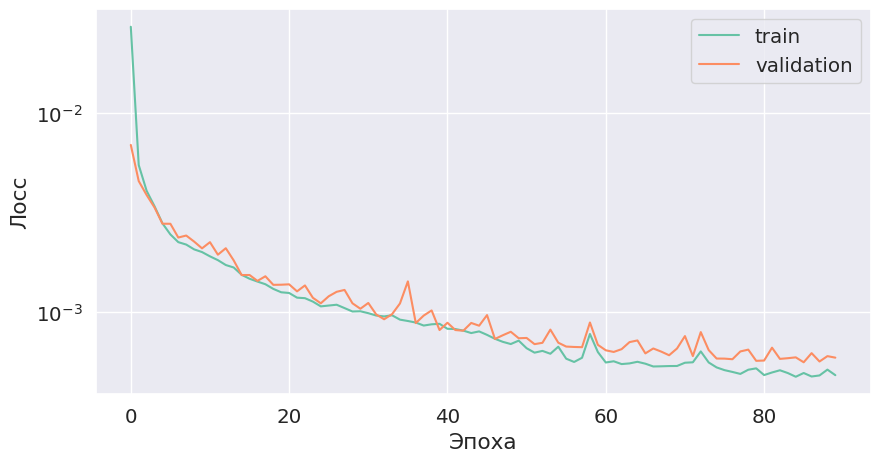

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm_model.parameters(), lr=1e-3, weight_decay=1e-5)

lstm_model, _ = train_ts_model(
    lstm_model,
    criterion,
    optimizer,
    train_batch_gen,
    validation_batch_gen,
    num_epochs=90, # todo back to 90
)

Зафиксируем некоторые константы:
* $h = 48\times7\ измерений = 7\ суток$ &mdash; горизонт прогнозирования;
* $\tau = 24\ измерения = 12\ часов$ &mdash; периодичность дообучения.

Теперь обсудим как должна выглядеть процедура дообучения. Пусть мы находимся в момент времени $T$ и уже обучили модель на всех имеющихся данных до момента времени $T$. Тогда необходимо выполнить следующие шаги.
1. Построить прогнозы на $h$ измерений вперед по одному наблюдению рекурсивно.
2. Подождать, пока поступят следующие $\tau$ измерений, и добавить их к обучающей выборке.
3. При необходимости удалить из обучающей выборки несколько старых измерений.
4. Произвести несколько итераций backpropagation для имеющейся нейронной сети и вернуться к шагу 1.

Вам необходимо реализовать эту процедуру и просимулировать ее применение. Стартовать следует из состояния, в котором модель обучена только на обучающей части временного ряда. После каждой итерации рисуйте график, на котором отображены:
* обучающая и тестовая часть данных разными цветами;
* прогнозы на данной итерации;
* текущий момент времени вертикальной пунктирной линией.

Таким образом, у вас должна получиться последовательность графиков, которая позволит проследить динамику дообучения. Стройте графики так, чтобы их можно было визуально сравнивать. 

Кроме того, после каждой итерации считайте ошибку прогнозирования по метрикам RMSE, MAE, MAPE 
- на длину горизонта прогнозирования $h$,
- на $\tau$ измерений вперед.

Постройте **графики изменения ошибок** при дообучении модели.

Для экспериментов полезно использовать
* `IPython.display.clear_output(wait=True)` &mdash; непосредственно до начала отрисовки каждого графика для его непрерывного обновления, **отключите эту команду при финальном запуске перед отправкой на проверку**;
* `time.sleep(some_seconds)` &mdash; визуальная задержка в момент поступления новых данных.

In [44]:
h = 48 * 7
tau = 24

In [45]:
weeks = [test_data_normalized[i:i + h] for i in range(0, len(test_data_normalized) - h, tau)]

Эпоха 25 из 25 выполнена за 0.635 сек.
  train loss: 	0.000071
  validation loss: 	0.000156


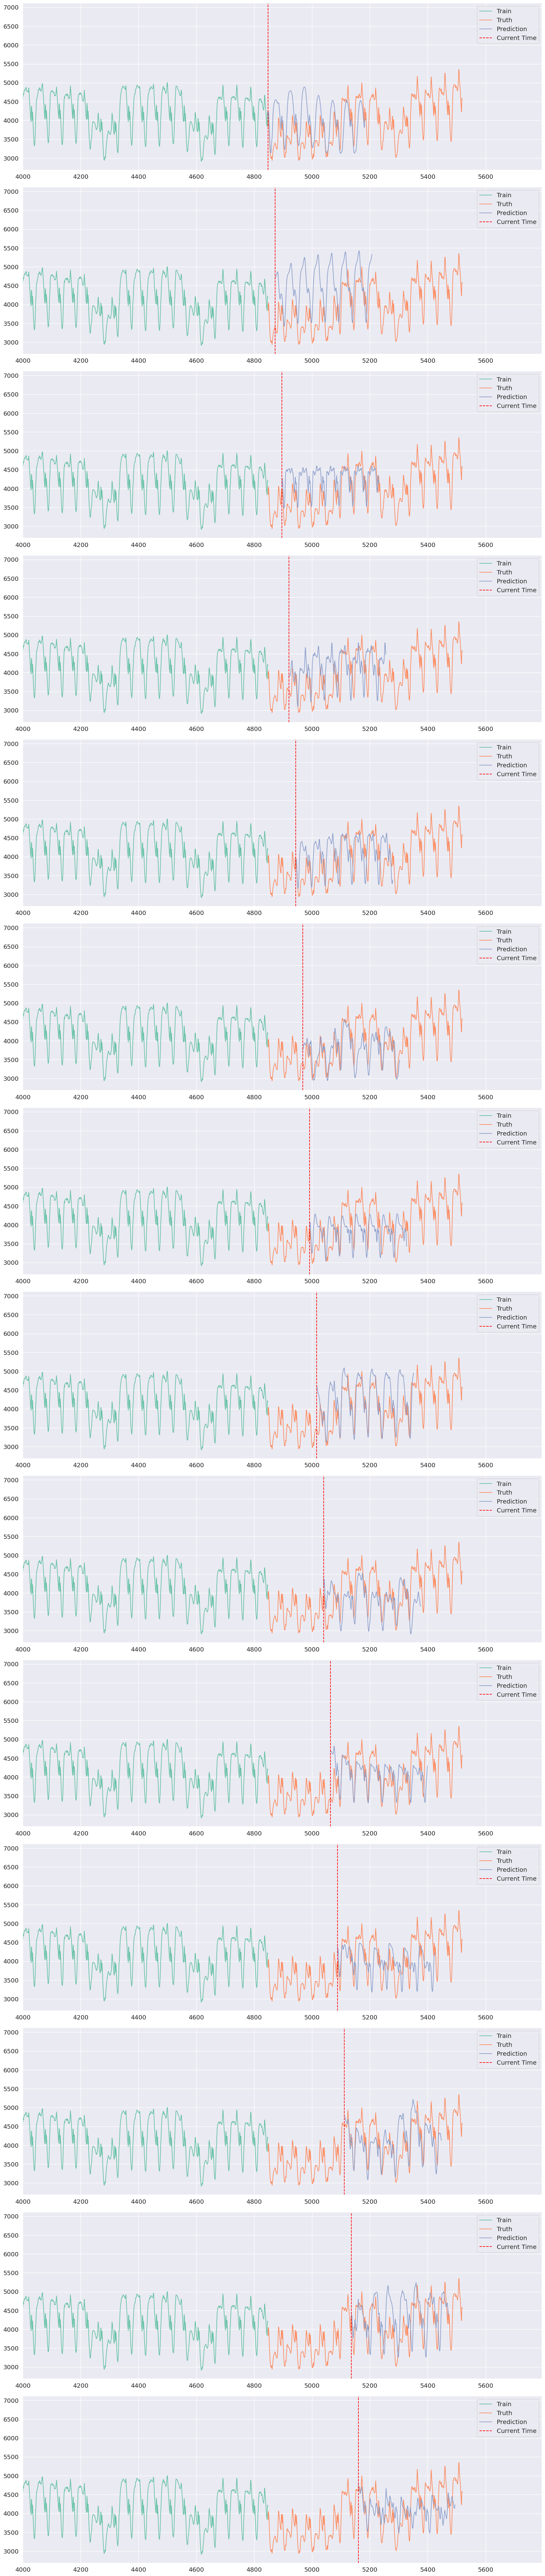

In [46]:
# Функция для вычисления RMSE, MAE, MAPE
def compute_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return rmse, mae, mape

# Списки для хранения ошибок
errors_h = []  # Ошибки на длину горизонта h
errors_tau = []  # Ошибки на tau измерений вперед

preds_to_add_train = list(train_data_normalized.copy())
tmp_data = train_data_normalized.copy()

# Настроим общее количество строк и столбцов для подграфиков
n_rows = len(weeks)
n_cols = 1

# Создаем единую фигуру для всех графиков
plt.figure(figsize=(18, 6 * n_rows))

for i, week in enumerate(weeks):
    lstm_model.eval()
    with torch.no_grad():
        lstm_result = evaluate_ts_model(
            lstm_model, week, test_data_normalized[i * tau : i * tau + h]
        )
    
    lstm_result = np.array(lstm_result, ndmin=2)
    lstm_result = scaler.inverse_transform(lstm_result)
    
    # Вычисление ошибок
    true_values_h = test_data[i * tau : i * tau + h].to_numpy()
    true_values_tau = test_data[i * tau : i * tau + tau].to_numpy()
    
    rmse_h, mae_h, mape_h = compute_metrics(true_values_h, lstm_result[:h])
    rmse_tau, mae_tau, mape_tau = compute_metrics(true_values_tau, lstm_result[:tau])
    
    errors_h.append((rmse_h, mae_h, mape_h))
    errors_tau.append((rmse_tau, mae_tau, mape_tau))
    
    tmp_data = np.concatenate([tmp_data, week[:tau]])
    tmp_dataset = TSDataset(tmp_data, n_past)

    generator = torch.Generator().manual_seed(0)
    train_dataset, validation_dataset = random_split(tmp_dataset, lengths=[0.8, 0.2], generator=generator)
    train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=True)
    validation_batch_gen = DataLoader(validation_dataset, batch_size, shuffle=False)

    lstm_model, _ = train_ts_model(
        lstm_model,
        criterion,
        optimizer,
        train_batch_gen,
        validation_batch_gen,
        num_epochs=25,
        plot_flag=False
    )
    
    # Визуализация прогнозов в подграфиках
    plt.subplot(n_rows, n_cols, i + 1)  # Это определит, в какой подграфик поместится текущий график
    plt.plot(df.index[: len(train_data)], train_data["Consumption"], label="Train")
    plt.plot(
        df.index[len(train_data) : len(train_data) + len(test_data)],
        test_data["Consumption"],
        label="Truth",
    )
    plt.plot(
        df.index[len(train_data) + i * tau : len(train_data) + i * tau + h],
        lstm_result[:, 0],
        label="Prediction",
    )
    plt.axvline(
        x=len(train_data) + i * tau, color="r", linestyle="--", label="Current Time"
    )
    plt.legend()
    plt.xlim([4000, None])

plt.tight_layout()  # Чтобы графики не накладывались друг на друга
plt.show()


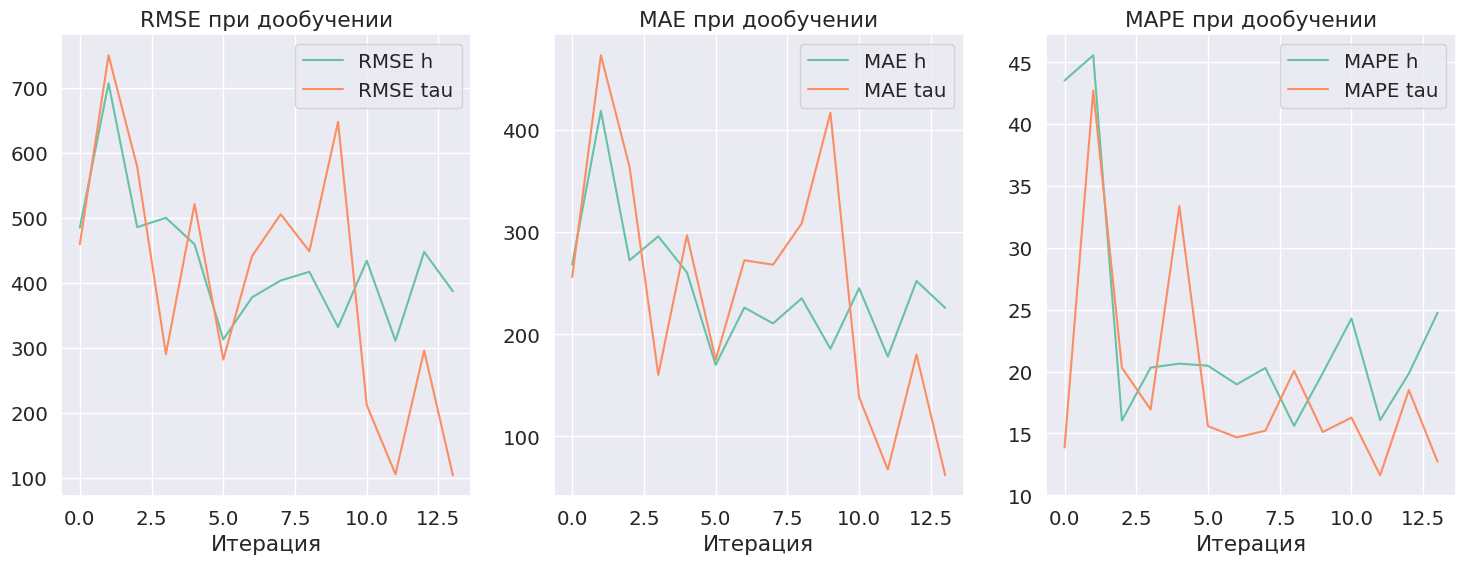

In [47]:
# Графики ошибок
errors_h = np.array(errors_h)
errors_tau = np.array(errors_tau)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(errors_h[:, 0], label='RMSE h')
plt.plot(errors_tau[:, 0], label='RMSE tau')
plt.xlabel("Итерация")
plt.legend()
plt.title('RMSE при дообучении')

plt.subplot(1, 3, 2)
plt.plot(errors_h[:, 1], label='MAE h')
plt.plot(errors_tau[:, 1], label='MAE tau')
plt.xlabel("Итерация")
plt.legend()
plt.title('MAE при дообучении')

plt.subplot(1, 3, 3)
plt.plot(errors_h[:, 2], label='MAPE h')
plt.plot(errors_tau[:, 2], label='MAPE tau')
plt.xlabel("Итерация")
plt.legend()
plt.title('MAPE при дообучении')

plt.show()

Сделайте выводы.

**Выводы**

Модель действительно смогла успешно дообучиться на новых данных, а потому увиедела новые зависимости во врмененном ряду. Это является явным плюсом по сравнению с офлайн обучением.

Заметим, ошибка ведет себя достаточно хаотично на протяжении итераций.